<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/simulation/PDE_IVP_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1次元の拡散方程式

拡散方程式は
\begin{equation}
    \frac{∂ρ}{∂t}=D\nabla^2\rho.
\end{equation}

まずは1次元の場合で、適切に規格化して$D=1$として解く.

まず数値計算の設定を行う

In [151]:
import numpy as np
from scipy import sparse

x_min, x_max = 0.1, 5
x_list = np.arange(-x_max, x_max, x_min)

中心差分では
\begin{equation}
    \frac{∂^2ρ}{∂x^2}(x_i)
    \simeq \frac{1}{h^2}(ρ(x_{i+1})-2ρ(x_i)+ρ(x_{i-1})).
\end{equation}
境界条件は十分遠方では0となる想定で課す。
今回はディリクレ境界条件で
\begin{equation}
    ∂ρ(x_0)=∂ρ(x_N)=0 
    ⇒ x_{-1}≃x_0, x_N≃x_{N+1}
\end{equation}
とする。
これに対応して係数行列を修正する。

In [152]:
x_1 = sparse.lil_matrix(sparse.eye(len(x_list), k=-1))
x_1[0, :] = 0
x_1[0, 0] = 1
x_1 = sparse.csr_matrix(x_1)

x0 = sparse.identity(len(x_list))

x1 = sparse.lil_matrix(sparse.eye(len(x_list), k=1))
x1[-1, :] = 0
x1[-1, -1] = 1
x1 = sparse.csr_matrix(x1)

coeff_mat = (x1 -2 * x0 + x_1) / (x_min ** 2)

初期条件と積分の詳細を決める。

[数値解の不安定性より時間方向の刻み幅は空間方向の刻み幅に対して十分に小さく取る必要がある](http://www.nibb.ac.jp/miyakohp/asari/htdocs/?page_id=60)。

In [153]:
rho_start = np.zeros(len(x_list))
rho_start[int(len(x_list)/2)] = 1

t_min, t_max = 0.005, 0.1
t_list = np.arange(0, t_max, t_min)

scipy で数値積分

In [154]:
from scipy.integrate import solve_ivp

def diff_operator(t, x_list):
    return coeff_mat * x_list

rho_sol = solve_ivp(diff_operator, t_span=(0, t_max), y0=rho_start, 
                    method="RK45", dense_output=True, rtol=1e-8)
rho_list = rho_sol.sol(t_list).T

日本語化も含めて matplotlib を読み込み

In [155]:
%%capture
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.animation as animation

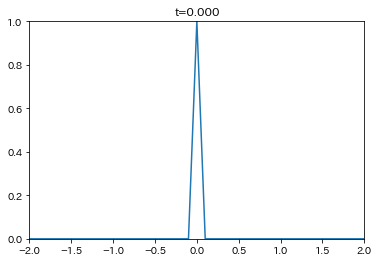

In [156]:
fig, ax = plt.subplots()

# 共通設定・初期設定
ax.set_xlim([-2, 2])
ax.set_ylim([0, 1])
line, = ax.plot([], [])

# 更新の関数
def animate(frame):
    t = t_list[frame]
    rho = rho_list[frame]
    ax.set_title(f"t={t:.3f}")
    line.set_data(x_list, rho)
    return (line)

ani = animation.FuncAnimation(fig, animate, frames=len(t_list), interval=100)
ani.save("./diffusion_1d.gif", writer="pillow", dpi=300)

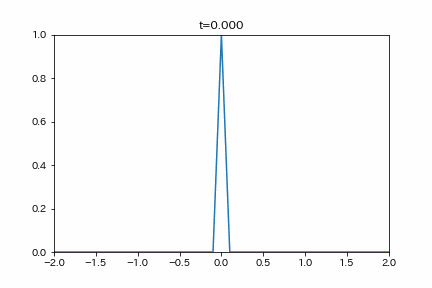

In [157]:
from IPython.display import Image

# アニメーション再生
Image("./diffusion_1d.gif", format='png')

## 非線形放物線型偏微分方程式：バーガース方程式

\begin{equation}
\frac{∂u(x,t)}{∂t}+u(x,t)\frac{∂u(x,t)}{∂x}=ν\frac{∂^2u(x,t)}{∂x^2}
\end{equation}

## 非線形3階偏微分方程式：KdV 方程式

- 初期値問題として解く
- 空間方向は周期境界条件

[python で学ぶ計算物理](http://www.physics.okayama-u.ac.jp/~otsuki/lecture/CompPhys2/pde/kdv.html)から移植。典型的なパラメータの

\begin{equation}
\frac{∂u(x,t)}{∂t}+6u(x,t)\frac{∂u(x,t)}{∂x}+\frac{∂^3u(x,t)}{∂x^3}=0
\end{equation}

を数値的に解く。

空間差分による係数行列を定義

In [158]:
def make_differential_ops(nx: int, dx: float):
    # 周期境界条件
    f0 = np.identity(nx, dtype=int)  # f_{i}
    f1 = np.roll(f0, 1, axis=1)  # f_{i+1}
    f2 = np.roll(f0, 2, axis=1)  # f_{i+2}
    f_1 = f1.transpose()  # f_{i-1}
    f_2 = f2.transpose()  # f_{i-2}

    # (f_{i+1} - f_{i-1}) / (2 dx)
    deriv1 = sparse.csr_matrix(f1 - f_1) / (2.0 * dx)

    # (f_{i+1} - 2f_{i} + f_{i-1}) / (dx^2)
    deriv2 = sparse.csr_matrix(f1 - 2.0 * f0 + f_1) / dx**2

    # (f_{i+2} - 2f_{i+1} + 2f_{i-1} - f_{i-2}) / (2 dx^3)
    deriv3 = sparse.csr_matrix(f2 - 2.0 * f1 + 2.0 * f_1 - f_2) / (2.0 * dx**3)

    return deriv1, deriv2, deriv3

KdV 方程式の空間差分による係数行列を定義

In [159]:
def f_kdv(t, u, df1, df3):
    u_x = df1.dot(u)
    u_xxx = df3.dot(u)
    return -6.0 * u * u_x - u_xxx

時間方向へ数値積分を実施

In [160]:
def kdv_integrate():
    # 空間メッシュ数
    nx = 1000
    # 空間幅
    x_max = 100.0
    # 空間メッシュ
    x = np.linspace(0, x_max, nx, endpoint=False)
    # 空間刻み幅
    dx = x[1] - x[0]
    print(f"dx = {dx}")

    # 初期条件
    u0 = np.sin(x * (2.0 * np.pi / x_max))

    # 微分演算子
    op_df1, _, op_df3 = make_differential_ops(nx, dx)

    print("計算開始...")
    t_max = 10.0
    sol = solve_ivp(f_kdv, (0, t_max), u0, args=(op_df1, op_df3),
                    dense_output=True, rtol=1e-8)
    print(sol.message)
    print(f" 時刻ステップ数 : {sol.t.size}")
    print(f" 時刻最小刻み幅 : {min(np.diff(sol.t))}")
    print(f" 時刻最大刻み幅 : {max(np.diff(sol.t))}")

    # 時間メッシュ数
    nt = 101
    # 時間メッシュ
    t = np.linspace(0, t_max, nt)
    # 時間メッシュ幅
    dt = t[1] - t[0]
    print(f"dt = {dt}")

    # u(x, t)
    u_xt = sol.sol(t)  
    # u(t, x)
    u_tx = u_xt.T  
    print(f"u(t, x) の形状: {u_tx.shape}")

    np.savez("kdv_solve_ivp", x=x, t=t, u_tx=u_tx)

In [161]:
kdv_integrate()

dx = 0.1
計算開始...
The solver successfully reached the end of the integration interval.
 時刻ステップ数 : 24471
 時刻最小刻み幅 : 0.0002880236208611109
 時刻最大刻み幅 : 0.03763835219541923
dt = 0.1
u(t, x) の形状: (101, 1000)


In [162]:
import matplotlib.pyplot as plt
from matplotlib import animation

def save_animation(x, t, u_tx, ymin, ymax, filename):
    fig, ax = plt.subplots()

    # 共通設定
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")
    ax.set_ylim((ymin, ymax))

    # list of plot
    artists = []
    for t_idx in range(t.size):
        artist = ax.plot(x, u_tx[t_idx, :], '-b')
        # transform 指定で枠(左下)を基準にした挿入
        artist += [ax.text(0.05, 1.05, f"t = {t[t_idx]: .2f}", transform=ax.transAxes)]
        artists.append(artist)

    # アニメーション生成 (100ms 毎に更新=10fps)
    anim = animation.ArtistAnimation(fig, artists, interval=100, repeat=False)

    # アニメーション保存 (writer="pillow" or "imagemagick" for GIF)
    anim.save(filename, writer="pillow")  
    print(f"saved as '{filename}'")

アニメーションを描画

npz.files = ['x', 't', 'u_tx']
x.shape = (1000,)
t.shape = (101,)
u_tx.shape = (101, 1000)
アニメーション生成中...
saved as 'kdv_solve_ivp.gif'


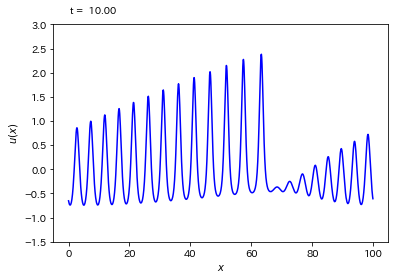

In [163]:
def make_kdv_animation():
    # 結果読み込み
    npz = np.load("kdv_solve_ivp.npz")
    print(f"npz.files = {npz.files}")

    x = npz['x']
    t = npz['t']
    u_tx = npz['u_tx']
    print(f"x.shape = {x.shape}")
    print(f"t.shape = {t.shape}")
    print(f"u_tx.shape = {u_tx.shape}")

    print("アニメーション生成中...")
    save_animation(x, t, u_tx, ymin=-1.5, ymax=3.0, filename="kdv_solve_ivp.gif")

make_kdv_animation()

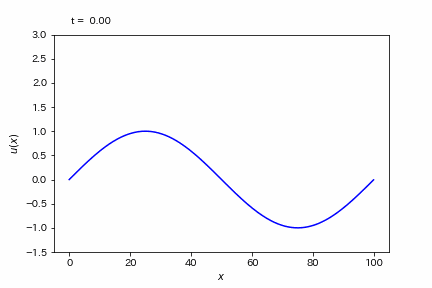

In [164]:
import IPython

# アニメーション再生
IPython.display.Image("kdv_solve_ivp.gif", format='png')